# Παγαγωγικά Δίκτυα Μάθησης με Αντιπαλότητα - Generative Adversarial Networks (GAN)

Όπως είπαμε και στη διάλεξη, τα Παραγωγικά Δίκτυα Μάθησης με Αντιπαλότητα - Generative Adversarial Networks (GAN) είναι ένα  παραγωγικό (generative) σύστημα μηχανικής μάθησης το οποίο [προτάθηκε  από τον Goodfellow το 2014](https://arxiv.org/abs/1406.2661), και αποτελείται από δύο διακριτά νευρωνικά δίκτυα:
1. Τον γεννήτορα (generator), ο οποίος προσπαθεί να δημιουργήσει νέα δείγματα δεδομένων, όμοια προς τα υπάρχοντα
2. Τον διευκρινιστή (discriminator), ο οποίος καλείται να αναγνωρίσει αν ένα δείγμα δεδομένων είναι "αληθινό" ή "ψεύτικο"

Η είσοδος του δικτύου του γεννήτορα είναι μια σειρά τυχαίων αριθμών (θορύβου), τα οποία καλούνται λανθάνοντα δείγματα (latent samples). Όπως είπαμε και παραπάνω, ο γεννήτορας  προσπαθεί να δημιουργήσει δείγματα, τα οποία τελικά προέρχονται από την επιθυμητή κατανομή των δεδομένων. Ο θόρυβος που λαμβάνει στην είσοδό του διέρχεται μέσω των διαφορίσημων συναρτήσεων ενεργοποίησης του δικτύου και μετασχηματίζεται, μέσω της εκπαίδευσης, με τέτοιο τρόπο έτσι ώστε στην έξοδό του να παράξει "ρεαλιστικά δεδομένα". Άρα, στη συγκεκριμένη περίπτωση, ο ρόλος της εισόδου είναι η εισαγωγή τυχαιότητας στο σύστημα, η οποία επιτρέπει στον γεννήτορα να παράξει εξόδους που θα καλύπτουν όλο το εύρος των υπό εξέταση δεδομένων.

Το δίκτυο του διευκρινιστή από την άλλη αποτελείται από έναν ταξινομητή, ο οποίος εκπαιδεύεται μέσω επιβλεπόμενης μάθησης σε ένα dataset και μαθαίνει να αναγνωρίζει αν η έξοδος που παράγει ο γεννήτορας ανταποκρίνεται στα δεδομένα στα οποία έχει εκπαιδευτεί ο διευκρινιστής ή όχι.

Η εκπαίδευση ενός GAN προσομοιάζει με ένα παιχνίδι minimax. Ο γεννήτορας προσπαθεί να μάθει να δημιουργεί δεδομένα με τέτοιο τρόπο που ο διευκρινιστής δε θα μπορεί πλέον να αναγνωρίζει αν είναι ψεύτικα ή όχι. Ο ανταγωνισμός αυτός μεταξύ των δύο δικτύων βελτιώνει τη δυνατότητα μάθησης του συνολικού δικτύου, μέχρις ότου ο γεννήτορας μάθει να δημιουργεί "ρεαλιστικά" δεδομένα.

Στο συγκεκριμένο notebook θα δούμε πως μπορούμε να χρησιμοποιήσουμε τα GANs για την παραγωγή εικόνων ψηφίων, παρόμοιων με αυτά που υπάρχουν στο γνωστό μας [MNIST dataset](http://yann.lecun.com/exdb/mnist/).

Για την ταχύτερη εκτέλεση του κώδικα, στην περίπτωση που χρησιμοποιείτε Google Colaboratory, συστήνεται να επιλέξετε τις κάρτες γραφικών ως τον επιταχυντή υλικού (hardware accelerator). Αυτό επιτυγχάνεται επιλέγοντας το μενού Runtime και στη συνέχεια το υπομενού Change Runtime type. Στο νέο παράθυρο που θα εμφανιστεί επιλέγουμε GPU στο hardware accelerator και κατόπιν Save.

Η εκπαίδευση των GANs στα κελιά που θα ακολουθήσουν θα χρειαστεί κάποιο χρόνο, οπότε ενδέχεται να εμφανιστεί παράθυρο σφάλματος με τίτλο “Runtime disconnected” και μήνυμα “The connection to the runtime has timed out”. Σε αυτή την περίπτωση πατάμε “Reconnect” και συνδεόμαστε ξανά με το περιβάλλον εκτέλεση του κώδικα.

## Βιβλιοθήκες

Ξεκινάμε εισάγοντας τις βιβλιοθήκες που πρόκειται να χρησιμοποιήσουμε (κυρίως το submodule *keras* του tensorflow και δευτερευόντως το *scikit-learn,* το *numpy* και το *matplotlib*)

In [ ]:
from tensorflow import GradientTape, ones_like, zeros_like, function
from tensorflow import print as tfprint
from tensorflow.data import Dataset

from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization, Dense, LeakyReLU
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.initializers import RandomNormal
from tensorflow.random import normal

from sklearn.preprocessing import MinMaxScaler

import numpy as np
import matplotlib.pyplot as plt

# Θέτουμε σπορά (seed) στη γεννήτρια ψευδο-τυχαίων αριθμών για να λάβουμε
# ίδια αποτελέσματα

np.random.seed(2022)
%matplotlib inline

### Dataset

Αρχικά φορτώνουμε το MNIST Dataset

In [ ]:
# Φόρτωση συνόλου δεδομένων
(X_train, y_train), (X_test, y_test) = mnist.load_data()

11501568/11490434 [==============================] - 0s 0us/step


Ας δούμε μια χαρακτηριστική εικόνα (ψηφίο) για την κάθε ετικέτα

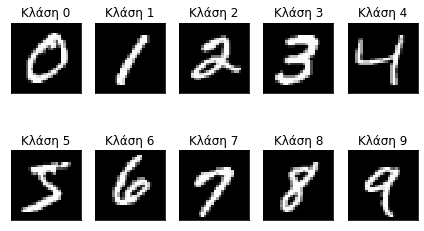

In [ ]:
fig = plt.figure()
for i in range(10):
    plt.subplot(2, 5, i+1)
    x_y = X_train[y_train == i]
    plt.imshow(x_y[0], cmap='gray', interpolation='none')
    plt.title("Κλάση %d" % (i))
    plt.xticks([])
    plt.yticks([])
    
plt.tight_layout()

Μετασχηματίζουμε τις εικόνες από πίνακα $28\times28$ pixels σε να διάνυσμα $784$ χαρακτηριστικών. Επίσης τους αλλάζουμε κλίμακα, απεικονίζοντάς τες γραμμικά από το $[0, 255]$ στο $[0,1]$ με την χρήση του [MinMaxScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html) του scikit-learn

In [ ]:
print('Μέγεθος X_train:', X_train.shape)

#  Μετασχηματισμός εισόδου
X_train = X_train.reshape(60000, 28*28)
# Κανονικοποίηση εισόδου
scaler = MinMaxScaler(feature_range=(0,1))

X_train_scaled = scaler.fit_transform(X_train)

print('Μέγεθος X_train_scaled:', X_train_scaled.shape)

Μέγεθος X_train: (60000, 28, 28)
Μέγεθος X_train_scaled: (60000, 784)


## Simple GAN

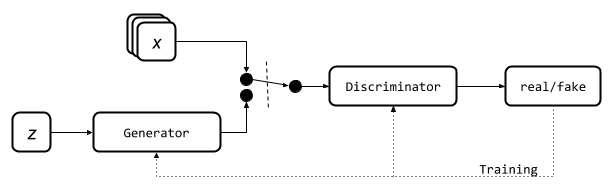

Η αντικειμενική συνάρτηση που προσπαθεί να βελτιστοποιήσει το απλό GAN είναι η παρακάτω:

 $ \underset{\theta_{g}}{min} \: \underset{\theta_{d}}{max} V(D,G) = \mathbb{E}_{x\sim p_{data}(x)} D_{\theta_{d}}(x) + \mathbb{E}_{z\sim p_{z}(z)} D_{\theta_{d}}(G_{\theta_{g}}(z))$
 

*  Ο διευκρινιστής $D$ θέλει να μεγιστοποιήσει την αντικειμενική συνάρτηση όσον αφορά τις παραμέτρους του ($\theta_d$), έτσι ώστε το $D(x)$ να είναι κατά το δυνατόν εγγύτερα στο $1$ (αληθινά δεδομένα) και το $D(G(z))$ κοντά στο $0$ (ψευδή δεδομένα)
*  Ο γεννήτορας $G$ θέλει να ελαχιστοποιήσει την αντικειμενική συνάρτηση όσον αφορά τις παραμέτρους του ($\theta_g$), έτσι ώστε το $D(G(z))$ να είναι εγγύτερα στο $1$

Ξεκινάμε ορίζοντας το μέγεθος του χώρου των λανθανουσών μεταβλητών $z$, ο οποίος πρόκειται να είναι ένα διάνυσμα μεγέθους $100$ χαρακτηριστικών 

In [ ]:
# Διάσταση χώρου λανθανουσών μεταβλητών
latent_dim = 100

# Διάστσαη εικόνας 28x28
img_dim = 28*28

Το δίκτυο του γεννήτορα είναι ένα πλήρως διασυνδεδεμένο βαθύ δίκτυο $3$ κρυφών επιπέδων, μεγέθους $128, 256$ και $512$ νευρώνων αντίστοιχα.

In [ ]:
# Δίκτυο γεννήτορα
generator = Sequential([
    # Πρώτο κρυφό επίπεδο
    Dense(128, 
          input_shape=(latent_dim,), 
          kernel_initializer=RandomNormal(stddev=0.02), 
          activation=LeakyReLU(alpha=0.2), name="hidden1"
    ),
    BatchNormalization(momentum=0.8, name="normalization1"),
    
    # Δεύτερο κρυφό επίπεδο
    Dense(256, activation=LeakyReLU(alpha=0.2), name="hidden2"),
    BatchNormalization(momentum=0.8, name="normalization2"),
    
     # Τρίτο κρυφό επίπεδο
    Dense(512, activation=LeakyReLU(alpha=0.2), name="hidden3"),
    BatchNormalization(momentum=0.8, name="normalization3"),
    
    # Επίπεδο εξόδου
    Dense(img_dim, activation='sigmoid', name="output")
], name="Simple_GAN_generator")

# Εμφάνιση σύνοψης δικτύου 
generator.summary()

Model: "Simple_GAN_generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 hidden1 (Dense)             (None, 128)               12928     
                                                                 
 normalization1 (BatchNormal  (None, 128)              512       
 ization)                                                        
                                                                 
 hidden2 (Dense)             (None, 256)               33024     
                                                                 
 normalization2 (BatchNormal  (None, 256)              1024      
 ization)                                                        
                                                                 
 hidden3 (Dense)             (None, 512)               131584    
                                                                 
 normalization3 (BatchNormal  (None, 512)     

Το δίκτυο του διευκρινιστή έχει αντίστοιχη δομή με αυτή του γεννήτορα, με τη διαφορά πως αλλάζει η είσοδος και η έξοδος.

In [ ]:
# Δίκτυο διευκρινιστή
discriminator = Sequential([
    # Πρώτο κρυφό επίπεδο
    Dense(128, 
          input_shape=(img_dim,), 
          kernel_initializer=RandomNormal(stddev=0.02), 
          activation=LeakyReLU(alpha=0.2), name="hidden1"
    ),

    # Δεύτερο κρυφό επίπεδο
    Dense(256, activation=LeakyReLU(alpha=0.2), name="hidden2"),
    
     # Τρίτο κρυφό επίπεδο
    Dense(512, activation=LeakyReLU(alpha=0.2), name="hidden3"),

    # Επίπεδο εξόδου
    Dense(img_dim, activation='sigmoid', name="output")
], name="Simple_GAN_discriminator")

# Εμφάνιση σύνοψης δικτύου 
discriminator.summary()

Model: "Simple_GAN_discriminator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 hidden1 (Dense)             (None, 128)               100480    
                                                                 
 hidden2 (Dense)             (None, 256)               33024     
                                                                 
 hidden3 (Dense)             (None, 512)               131584    
                                                                 
 output (Dense)              (None, 784)               402192    
                                                                 
Total params: 667,280
Trainable params: 667,280
Non-trainable params: 0
_________________________________________________________________


Με βάση την αντικειμενική συνάρτηση που ορίσαμε παραπάνω, έχουμε δύο εναλλασσόμενα στάδια εκπαίδευσης.

1. Ανάβαση κλισης (μεγιστοποίηση) για τον διευκρινιστή <br>
$ \underset{\theta_{d}}{max} \left[\mathbb{E}_{x\sim p_{data}(x)} D_{\theta_{d}}(x) + \mathbb{E}_{z\sim p_{z}(z)}D_{\theta_{d}}(G_{\theta_{g}}(z))\right]$

2. Κατάβαση κλισης (ελαχιστοποίηση) για τον γεννήτορα <br>
$ \underset{\theta_{g}}{min} \left[\mathbb{E}_{z\sim p_{z}(z)} D_{\theta_{d}}(G_{\theta_{g}}(z))\right]$

Ο γεννήτορας δηλαδή, προσπαθεί να ελαχιστοποιήσει την πιθανότητα ο διευκρινιστής να είναι σωστός. Αυτό το επιτυγχάνει παράγοντας κατά το δυνατόν ρεαλιστικά δεδομένα, έτσι ώστα να "ξεγελά" τον διευκρινιστή. Συνεπώς, σε αυτή την περίπτωση, η συνάρτηση απώλειας που χρησιμοποιείται είναι η $D(G(z))$.

Ο διευκρινιστής, από την άλλη, εκπαιδεύεται κανονικά όπως ένας ταξινομητής, στο να αναγνωρίζει αν η είσοδός του είναι αληθής η ψευδής. 

Πλέον, είμαστε έτοιμοι να εκπαιδεύσουμε το συνολικό GAN για 50 εποχές και για μέγεθος δέσμης (`batch_size`) 16. Ανά 10 εποχές εκπαίδευσης, θα ελέγχουμε οπτικά την ποιότητα των εικόνων που παράγει ο γεννήτορας.

Παραγόμενες εικόνες γεννήτορα (πριν την εκπαίδευση


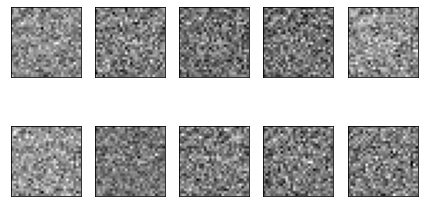

/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1096: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


Εποχή: 1/50, Απώλεια Γεννήτορα: 4.628, Απώλεια Διευκρινιστή: 0.110
Εποχή: 2/50, Απώλεια Γεννήτορα: 2.696, Απώλεια Διευκρινιστή: 0.286
Εποχή: 3/50, Απώλεια Γεννήτορα: 3.560, Απώλεια Διευκρινιστή: 0.299
Εποχή: 4/50, Απώλεια Γεννήτορα: 4.282, Απώλεια Διευκρινιστή: 0.320
Εποχή: 5/50, Απώλεια Γεννήτορα: 2.944, Απώλεια Διευκρινιστή: 0.124
Εποχή: 6/50, Απώλεια Γεννήτορα: 2.816, Απώλεια Διευκρινιστή: 0.270
Εποχή: 7/50, Απώλεια Γεννήτορα: 3.025, Απώλεια Διευκρινιστή: 0.153
Εποχή: 8/50, Απώλεια Γεννήτορα: 2.777, Απώλεια Διευκρινιστή: 0.212
Εποχή: 9/50, Απώλεια Γεννήτορα: 2.215, Απώλεια Διευκρινιστή: 0.171
Εποχή: 10/50, Απώλεια Γεννήτορα: 2.631, Απώλεια Διευκρινιστή: 0.218


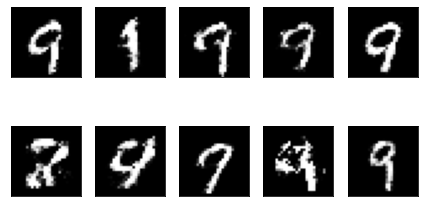

Εποχή: 11/50, Απώλεια Γεννήτορα: 2.698, Απώλεια Διευκρινιστή: 0.230
Εποχή: 12/50, Απώλεια Γεννήτορα: 2.689, Απώλεια Διευκρινιστή: 0.209
Εποχή: 13/50, Απώλεια Γεννήτορα: 2.102, Απώλεια Διευκρινιστή: 0.372
Εποχή: 14/50, Απώλεια Γεννήτορα: 2.172, Απώλεια Διευκρινιστή: 0.453
Εποχή: 15/50, Απώλεια Γεννήτορα: 1.870, Απώλεια Διευκρινιστή: 0.386
Εποχή: 16/50, Απώλεια Γεννήτορα: 2.122, Απώλεια Διευκρινιστή: 0.446
Εποχή: 17/50, Απώλεια Γεννήτορα: 2.482, Απώλεια Διευκρινιστή: 0.328
Εποχή: 18/50, Απώλεια Γεννήτορα: 2.268, Απώλεια Διευκρινιστή: 0.446
Εποχή: 19/50, Απώλεια Γεννήτορα: 1.730, Απώλεια Διευκρινιστή: 0.576
Εποχή: 20/50, Απώλεια Γεννήτορα: 2.238, Απώλεια Διευκρινιστή: 0.495


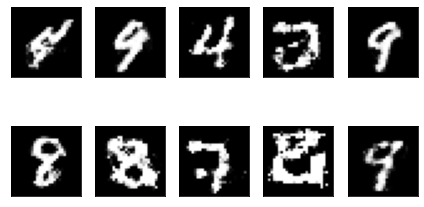

Εποχή: 21/50, Απώλεια Γεννήτορα: 2.240, Απώλεια Διευκρινιστή: 0.413
Εποχή: 22/50, Απώλεια Γεννήτορα: 1.946, Απώλεια Διευκρινιστή: 0.753
Εποχή: 23/50, Απώλεια Γεννήτορα: 2.083, Απώλεια Διευκρινιστή: 0.521
Εποχή: 24/50, Απώλεια Γεννήτορα: 1.894, Απώλεια Διευκρινιστή: 0.539
Εποχή: 25/50, Απώλεια Γεννήτορα: 2.167, Απώλεια Διευκρινιστή: 0.505
Εποχή: 26/50, Απώλεια Γεννήτορα: 1.942, Απώλεια Διευκρινιστή: 0.460
Εποχή: 27/50, Απώλεια Γεννήτορα: 2.084, Απώλεια Διευκρινιστή: 0.403
Εποχή: 28/50, Απώλεια Γεννήτορα: 2.028, Απώλεια Διευκρινιστή: 0.359
Εποχή: 29/50, Απώλεια Γεννήτορα: 2.136, Απώλεια Διευκρινιστή: 0.346
Εποχή: 30/50, Απώλεια Γεννήτορα: 1.734, Απώλεια Διευκρινιστή: 0.484


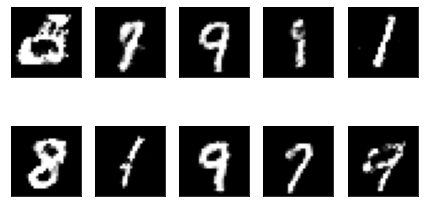

Εποχή: 31/50, Απώλεια Γεννήτορα: 2.232, Απώλεια Διευκρινιστή: 0.370
Εποχή: 32/50, Απώλεια Γεννήτορα: 1.913, Απώλεια Διευκρινιστή: 0.433
Εποχή: 33/50, Απώλεια Γεννήτορα: 2.212, Απώλεια Διευκρινιστή: 0.311
Εποχή: 34/50, Απώλεια Γεννήτορα: 2.207, Απώλεια Διευκρινιστή: 0.359
Εποχή: 35/50, Απώλεια Γεννήτορα: 2.086, Απώλεια Διευκρινιστή: 0.382
Εποχή: 36/50, Απώλεια Γεννήτορα: 2.884, Απώλεια Διευκρινιστή: 0.252
Εποχή: 37/50, Απώλεια Γεννήτορα: 2.216, Απώλεια Διευκρινιστή: 0.340
Εποχή: 38/50, Απώλεια Γεννήτορα: 2.221, Απώλεια Διευκρινιστή: 0.319
Εποχή: 39/50, Απώλεια Γεννήτορα: 2.449, Απώλεια Διευκρινιστή: 0.485
Εποχή: 40/50, Απώλεια Γεννήτορα: 1.937, Απώλεια Διευκρινιστή: 0.385


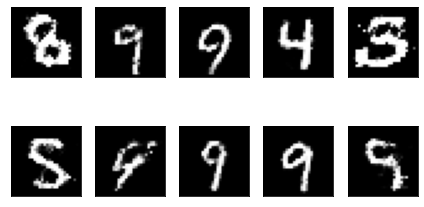

Εποχή: 41/50, Απώλεια Γεννήτορα: 2.323, Απώλεια Διευκρινιστή: 0.353
Εποχή: 42/50, Απώλεια Γεννήτορα: 2.742, Απώλεια Διευκρινιστή: 0.289
Εποχή: 43/50, Απώλεια Γεννήτορα: 2.175, Απώλεια Διευκρινιστή: 0.412
Εποχή: 44/50, Απώλεια Γεννήτορα: 2.668, Απώλεια Διευκρινιστή: 0.406
Εποχή: 45/50, Απώλεια Γεννήτορα: 2.283, Απώλεια Διευκρινιστή: 0.388
Εποχή: 46/50, Απώλεια Γεννήτορα: 2.147, Απώλεια Διευκρινιστή: 0.380
Εποχή: 47/50, Απώλεια Γεννήτορα: 2.094, Απώλεια Διευκρινιστή: 0.302
Εποχή: 48/50, Απώλεια Γεννήτορα: 2.217, Απώλεια Διευκρινιστή: 0.360
Εποχή: 49/50, Απώλεια Γεννήτορα: 2.224, Απώλεια Διευκρινιστή: 0.398
Εποχή: 50/50, Απώλεια Γεννήτορα: 2.057, Απώλεια Διευκρινιστή: 0.443


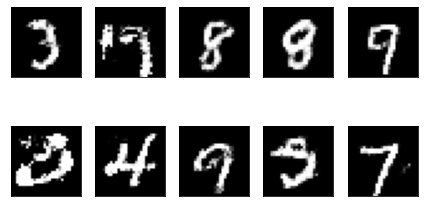

In [ ]:
def plot_images(imgs):
  """
  Εμφάνιση εικόνων σε πλέγμα 2 επί 5
  """
  for i in range(imgs.shape[0]):
    plt.subplot(2, 5, i+1)
    plt.imshow(imgs[i].numpy().reshape(28,28), cmap='gray')
    plt.xticks([])
    plt.yticks([])

  plt.tight_layout()
  plt.show()


@function
def train_step(images):
    """
    Βήμα εκπαίδευσης (επεξεργασία batch_size το πλήθος εικόνες)
    """
    noise = normal([batch_size, latent_dim])

    with GradientTape() as gen_tape, GradientTape() as disc_tape:
      generated_images = generator(noise, training=True)

      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)

      gen_loss = cross_entropy(ones_like(fake_output), fake_output)
      disc_loss = cross_entropy(zeros_like(fake_output), fake_output) + \
       cross_entropy(ones_like(real_output), real_output)


    gradients_of_generator = gen_tape.gradient(
        gen_loss, generator.trainable_variables
    )
    
    gradients_of_discriminator = disc_tape.gradient(
        disc_loss, discriminator.trainable_variables
    )

    generator_optimizer.apply_gradients(
        zip(gradients_of_generator, generator.trainable_variables)
    )
    
    discriminator_optimizer.apply_gradients(
        zip(gradients_of_discriminator, discriminator.trainable_variables)
    )

    return gen_loss, disc_loss



epochs = 50
batch_size = 16
samples = 10

# Συνάτηση απώλειας (δυαδική διασταυρούμενη εντροπία)
cross_entropy = BinaryCrossentropy(from_logits=True)

# Βελτιστοποιητής (Adam και για τα δύο δίκτυα)
generator_optimizer = Adam(1e-4)
discriminator_optimizer = Adam(1e-4)

# Δημιουργία συνόλου δεδομένων εκπαίδευσης από τις μετασχηματισμένες εικόνες
# και παροχή του στα δίκτυα αν batch_size πλήθος εικόνων
train_dataset = Dataset.from_tensor_slices(X_train_scaled).batch(batch_size)

d_losses = []
g_losses = []

print('Παραγόμενες εικόνες γεννήτορα (πριν την εκπαίδευση')
plot_images(generator(normal([samples, latent_dim]), training=False))

for epoch in range(1, epochs + 1):
  for image_batch in train_dataset:
    g_loss, d_loss = train_step(image_batch)

  g_losses.append(g_loss)
  d_losses.append(d_loss)
  tfprint(f'Εποχή: {epoch}/{epochs}, Απώλεια Γεννήτορα: {g_loss:.3f}, Απώλεια Διευκρινιστή: {d_loss:.3f}')

  if epoch % 10 == 0:
   plot_images(generator(normal([samples, latent_dim]), training=False))

Τέλος, ας σχεδιάσουμε τη μεταβολή των συναρτήσεων απώλειας για τον διευκρινιστή καθώς και για το συνολικό δίκτυο

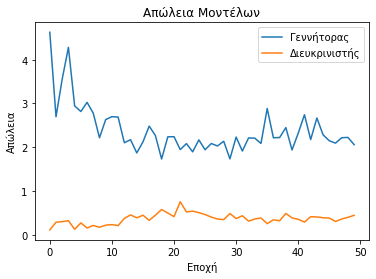

In [ ]:
# plotting the metrics
plt.plot(g_losses)
plt.plot(d_losses)
plt.title('Απώλεια Μοντέλων')
plt.ylabel('Απώλεια')
plt.xlabel('Εποχή')
plt.legend(['Γεννήτορας', 'Διευκρινιστής'], loc='upper right')
plt.show()